In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift, fft2, ifft2
from sklearn.cluster import KMeans
from skimage import exposure
import torch


In [2]:
# Import images from .npz files
# Extract data file paths
file_path = "/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_sept_data/npz_field_sweep/"

# TEMP SWEEP MOVIES
# movies = ['121855.npz', '118923.npz', '119486.npz', '119996.npz', '120506.npz', '121016.npz', '121405.npz', '121550.npz', '122365.npz', '122875.npz']

# FIELD SWEEP MOVIES OLD
#movies = ['Field_29mT.npz', 'Field_31mT.npz', 'Field_32mT.npz', 'Field_33mT.npz', 'Field_37mT.npz']

#SEPT DATA
# negative [0-12]
movies = ['neg23mT_553_50mW.npz', 'neg23mT_558_25mW.npz', 'neg25mT_553_50mW.npz', 'neg25mT_558_25mW.npz', 'neg27mT_553_50mW.npz',
          'neg27mT_558_25mW.npz', 'neg29mT_553_50mW.npz', 'neg29mT_558_25mW.npz', 'neg31mT_553_50mW.npz', 'neg31mT_558_25mW.npz',
          'neg33mT_553_50mW.npz', 'neg33mT_558_25mW.npz', 'neg35mT_553_50mW.npz',
# positive [13-24]
          'pos23mT_553_50mW.npz', 'pos23mT_558_25mW.npz', 'pos25mT_553_50mW.npz', 'pos25mT_558_25mW.npz', 'pos27mT_553_50mW.npz',
          'pos27mT_558_25mW.npz', 'pos29mT_553_50mW.npz', 'pos29mT_558_25mW.npz', 'pos31mT_553_50mW.npz', 'pos31mT_558_25mW.npz',
          'pos33mT_553_50mW.npz', 'pos33mT_558_25mW.npz']

# Define the movie you want to run GD and GS on as gif (gif = movies[i])
#movies = ['pos29mT_558_50mW.npz']
gif = movies[24]
print(gif)

movie = np.load(file_path + gif)
images = movie['data']
# Parameters:
#   iterations: Number of iterations to run the diffusion process.
#   kappa: Threshold for edge stopping (higher means less edge detection).
#   gamma: Step size (controls diffusion speed).
niter=50
kappa=30
gamma=.1
# intensity_data = torch.tensor(anisotropic_diffusion(intensity_data, niter=niter, kappa=kappa, gamma=gamma))
print('Tensor shape should be (X,128,128), where X is the number of images.')
print(images.shape)


pos33mT_558_25mW.npz
Tensor shape should be (X,128,128), where X is the number of images.
(113, 128, 128)


In [3]:
# Global parameters

# Extract data_theta, doesn't matter what image is extracted since we're just getting theta
DATA = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_temp_sweep/image_theta.npz')['data']
# DATA = np.load('/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/image_111001.npz')['data']
DATA_THETA = torch.atan2(torch.tensor(DATA[1]), torch.tensor(DATA[0]))
resolution = 10.8 #degrees
offset1 = torch.tensor(0., requires_grad=True)
offset2 = torch.tensor(0., requires_grad=True)
end_frame = len(images)
print(end_frame)
# for the model
MAX_ITER_OFFSET = 101
LR = 1e-2
OFFSET_ADJUSTMENT = 60

113


In [4]:
# Normalize data
def normalize_min_max(data):
    if isinstance(data, torch.Tensor):
        array = data.detach().numpy()
    else:
        array = data
    array_min = np.min(array)
    array_max = np.max(array)
    norm_array = (array - array_min) / (array_max - array_min)
    if isinstance(data, torch.Tensor):
        norm_tensor = torch.tensor(norm_array)
        return norm_tensor
    else:
        return norm_array

In [5]:
def mask_images(image, inner_radius=17, outer_radius=30, center_x=64, center_y=62):
    '''Masks signal inside inner_radius and outside outer_radius around the specified center.'''
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    radius = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    mask = (radius > inner_radius) & (radius < outer_radius)
    masked_image = np.copy(image)
    masked_image[~mask] = 0  
    return masked_image

In [6]:
### KMeans clustering

def fourier_hexagonal_clustering(image, n_clusters=2, outer_radius_filter=19, inner_radius_filter=3):
    """
    Extracts hexagonal patterns from a noisy image by filtering in Fourier space 
    and applying clustering to the filtered spatial domain image.
    
    Parameters:
    - image: 2D numpy array, the image to analyze.
    - n_clusters: int, the number of clusters to separate the hexagonal patterns.
    
    Returns:
    - clustered_image: Display of clustered regions in the filtered image.
    """
    
    # Step 1: Fourier Transform
    f_transform = fftshift(fft2(image))
    magnitude_spectrum = np.log(np.abs(f_transform) + 1)

    # Step 2: Apply a Circular Bandpass Filter to Enhance Hexagonal Patterns
    # Define center and radius range for bandpass (tweak based on image)
    center = np.array(f_transform.shape) // 2
    y, x = np.ogrid[:f_transform.shape[0], :f_transform.shape[1]]
    mask = ((x - center[1])**2 + (y - center[0])**2 <= outer_radius_filter**2) & \
           ((x - center[1])**2 + (y - center[0])**2 >= inner_radius_filter**2)
    
    # Apply mask to zero out other frequencies
    f_transform_filtered = f_transform * mask
    image_filtered = np.abs(ifft2(fftshift(f_transform_filtered)))
    filtered_image = mask_images(image_filtered)
    # plt.imshow(filtered_image)
    # plt.show()
    # Step 3: Rescale intensity for clearer clustering results
    filtered_image = exposure.rescale_intensity(filtered_image)
    
    # Step 4: Flatten image and apply K-means clustering to filtered data
    reshaped_data = filtered_image.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_data)
    labels = kmeans.labels_.reshape(filtered_image.shape)
    
    # Step 5: Plot the clustered regions in the filtered image
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.title("intensity")
    # plt.imshow(image)
    
    # plt.subplot(1, 2, 2)
    # plt.title("Clustered Regions in Filtered Image")
    # plt.imshow(labels)
    # plt.axis('off')
    # plt.show()


    return labels

print(images[0].shape)
labels = fourier_hexagonal_clustering(images[0])
print(labels.shape)



(128, 128)
(128, 128)


In [7]:

def fourier_hexagonal_clustering(image, n_clusters=2):
    """
    Extracts hexagonal patterns from a noisy image by filtering in Fourier space 
    and applying clustering to the filtered spatial domain image.
    
    Parameters:
    - image: 2D numpy array, the image to analyze.
    - n_clusters: int, the number of clusters to separate the hexagonal patterns.
    
    Returns:
    - clustered_image: Display of clustered regions in the filtered image.
    """
    
    # Step 4: Flatten image and apply K-means clustering to filtered data
    reshaped_data = image.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_data)
    labels = kmeans.labels_.reshape(image.shape)
    
    # Step 5: Plot the clustered regions in the filtered image
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.title("intensity")
    # plt.imshow(image)
    
    # plt.subplot(1, 2, 2)
    # plt.title("Clustered Regions in Filtered Image")
    # plt.imshow(labels)
    # plt.axis('off')
    # plt.show()


    return labels

print(images[0].shape)
labels = fourier_hexagonal_clustering(images[0])
print(labels.shape)


(128, 128)
(128, 128)


In [8]:
# CREATION OF K-MEANS FILTERS TO APPLY TO RAW DATA
kmeans_filter = []
for i in range(end_frame):
    label = fourier_hexagonal_clustering(images[i])
    kmeans_filter.append(label)

In [9]:
# GD FUNCTIONS

def k_val(fwhm):
    '''fwhm is your resolution given in degrees.

    This is derived based off the assumption that FWHM for the cosine 
    is approximately equal to a gaussian, which is a good assumption for this case
    Because FWHM for the cosine filter is approx equal to FWHM for a gaussian'''
    fwhm = np.deg2rad(fwhm)
    k = np.log(1/2) / (np.log(np.cos(3/2*fwhm)**2))
    return k

k = k_val(resolution)
print('k =', k)

n_folds = 6
def filter_function(k, theta, n_folds=n_folds):
    filter = torch.exp(k * torch.log((torch.cos(n_folds / 2 * theta))**2))
    return filter

def gradient_descent_optimize_offset(intensity, offset, k=k):
    opt = torch.optim.Adam([offset], lr=LR)
    for i in range(MAX_ITER_OFFSET):
        evaluate_image_theta = filter_function(k, DATA_THETA+offset)

        loss = -(torch.tensor(intensity) * evaluate_image_theta).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()
        filter = evaluate_image_theta.detach().numpy()
        tracked_im = filter + normalize_min_max(intensity)

        # set all values greater that .01 to 1 in filter
        filter_to_ones = evaluate_image_theta.detach().numpy()
        filter_to_ones[filter_to_ones > .1] = 1
        filter_to_ones[filter_to_ones <= .1] = 0

    return offset.item(), tracked_im, loss, filter_to_ones



k = 8.553968178278982


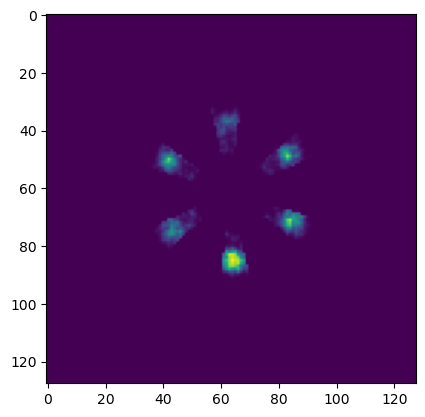

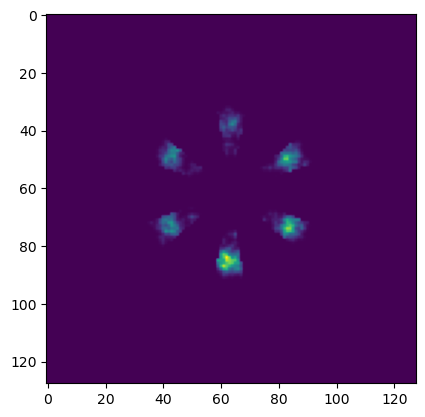

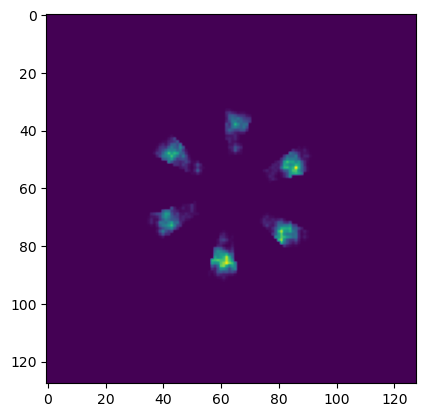

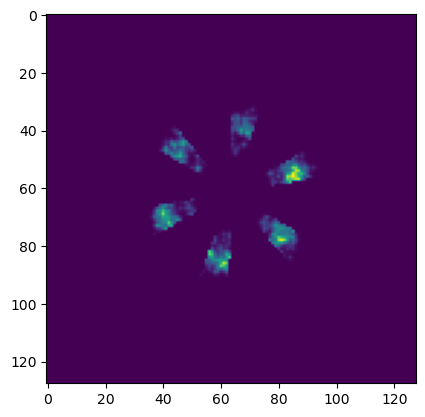

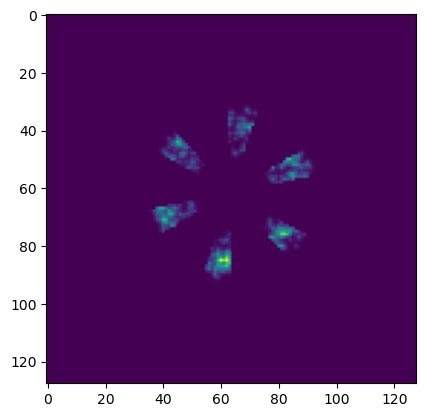

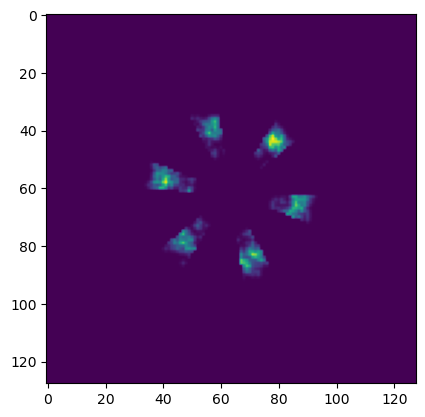

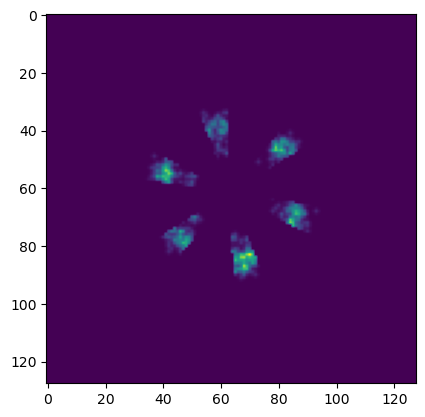

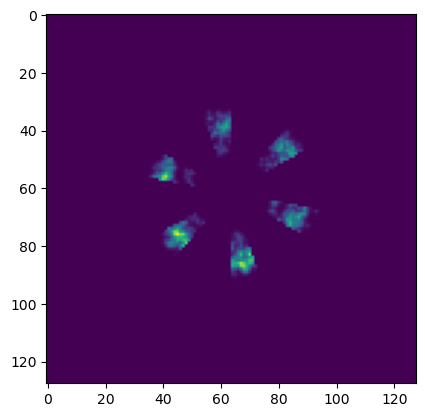

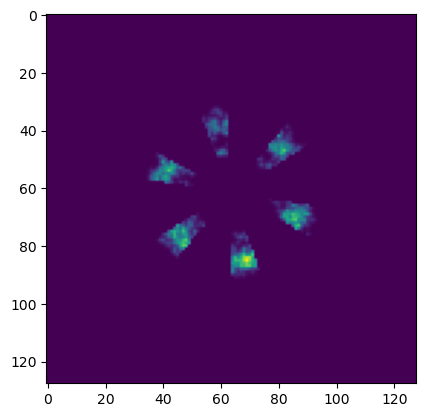

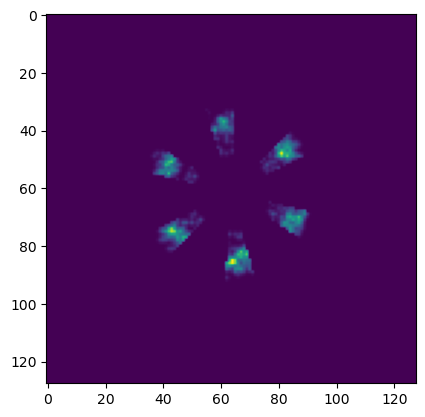

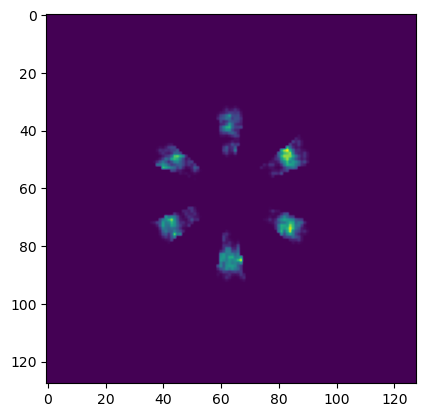

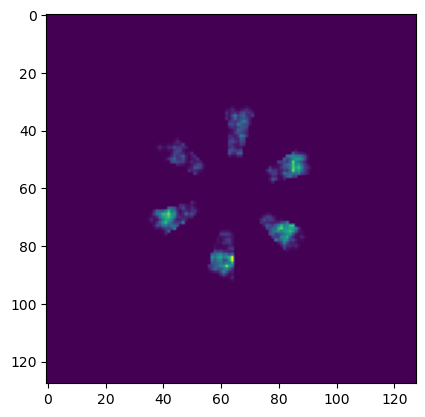

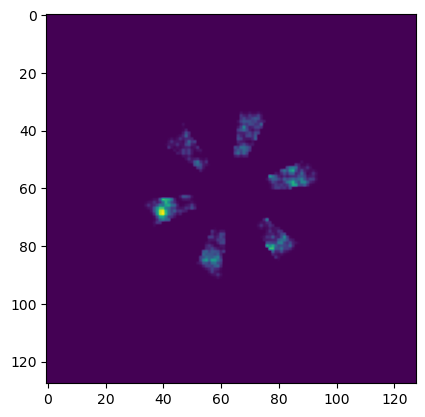

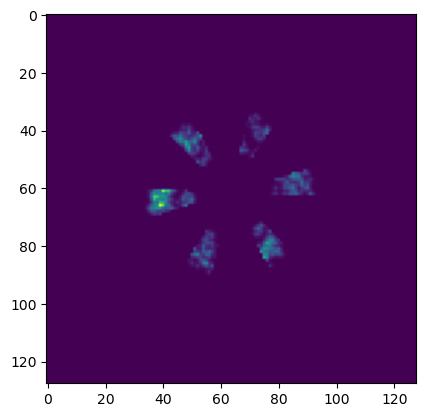

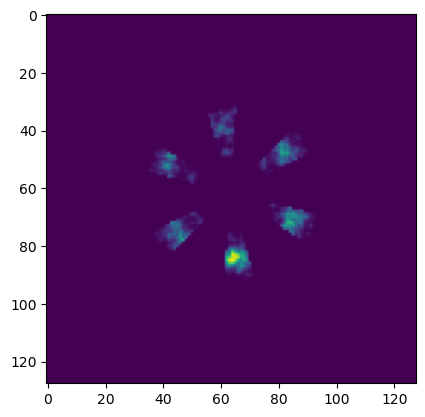

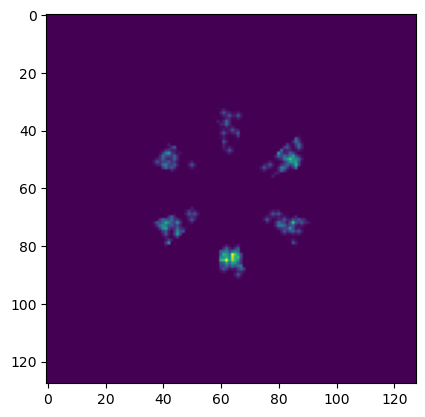

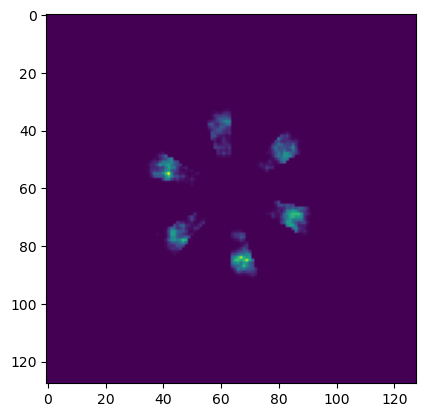

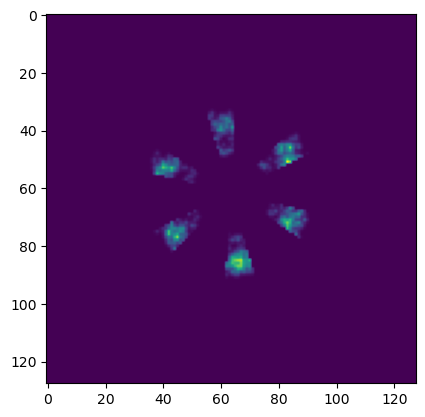

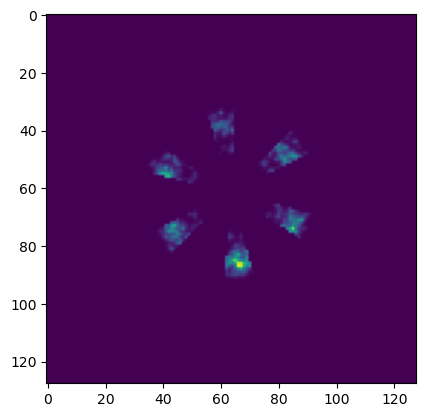

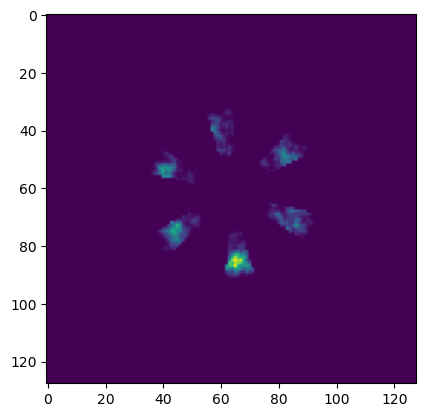

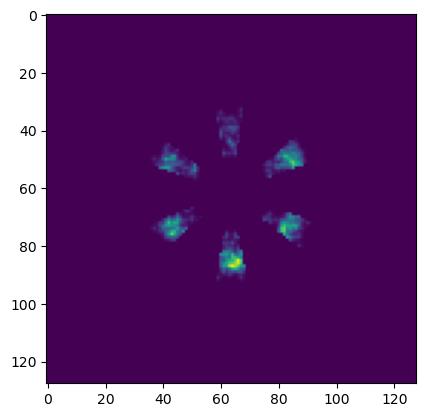

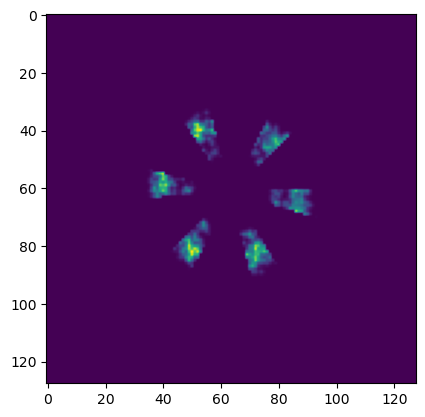

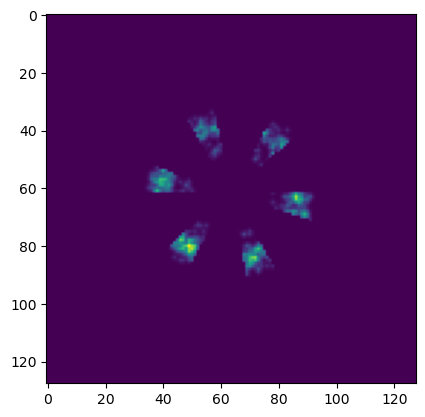

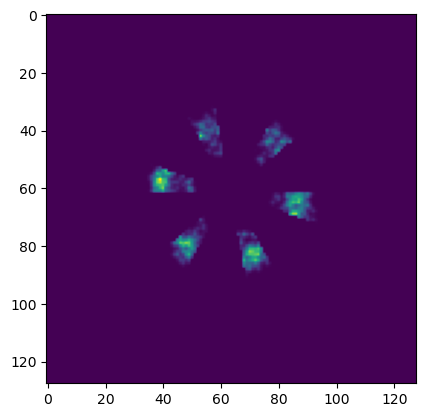

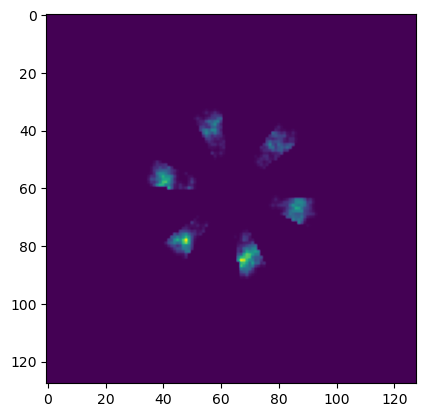

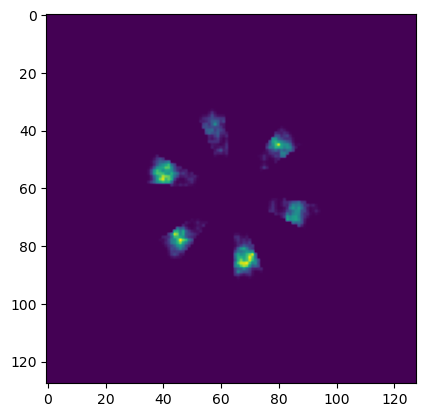

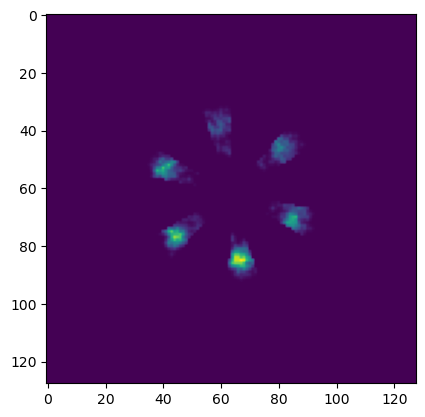

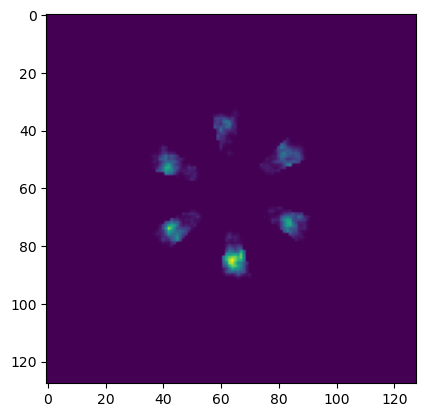

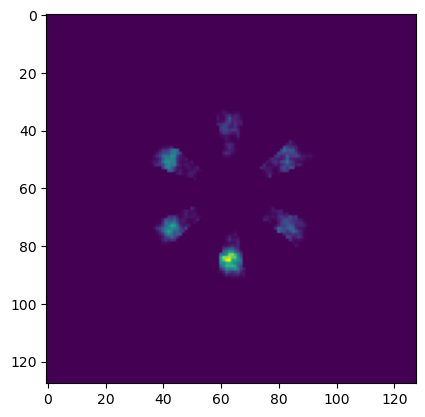

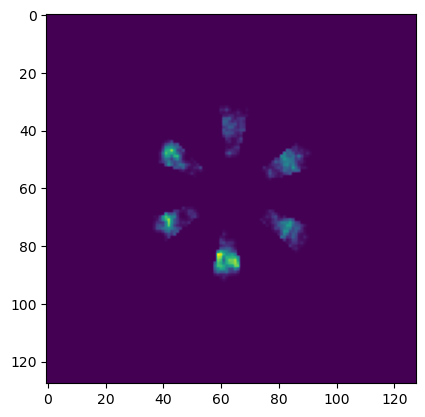

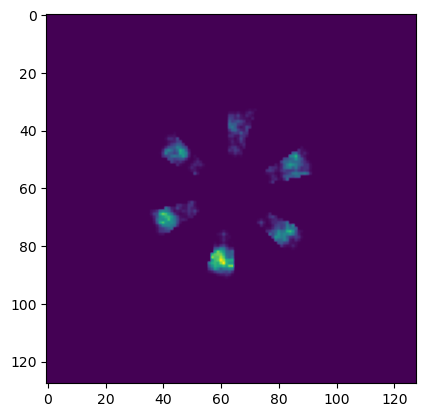

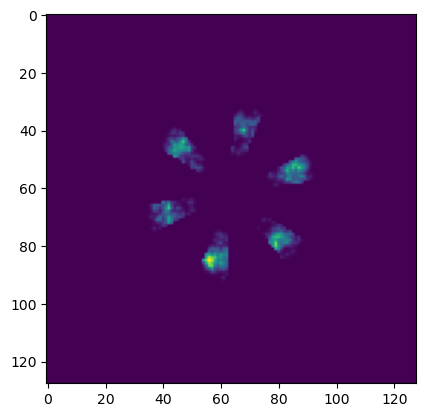

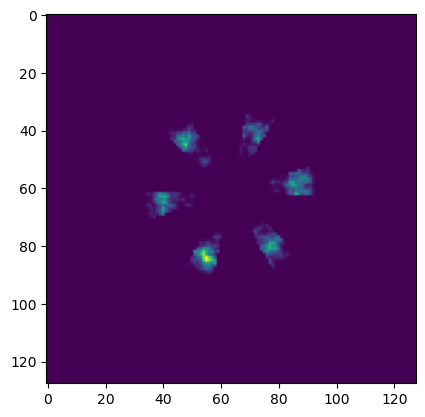

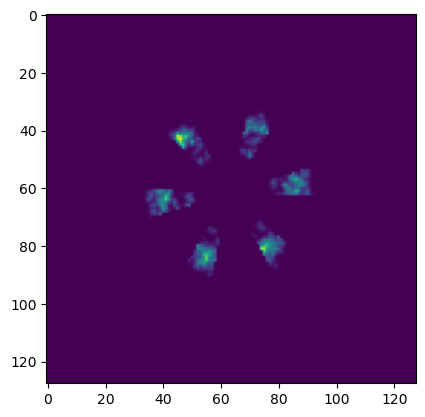

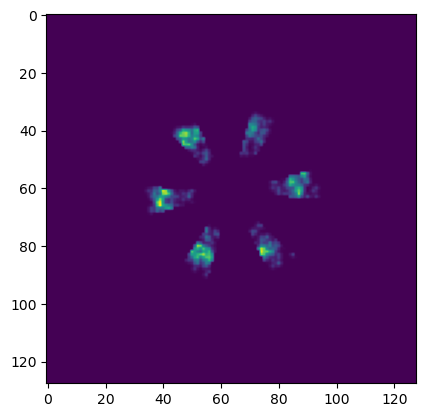

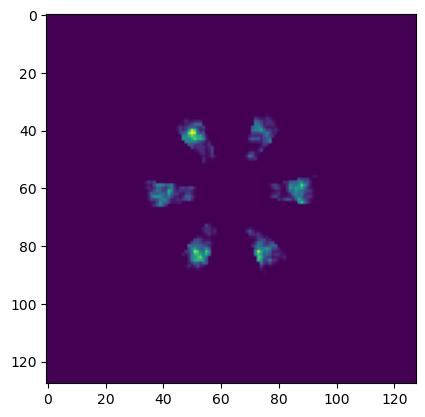

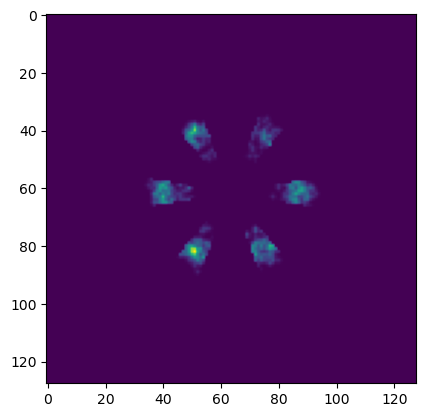

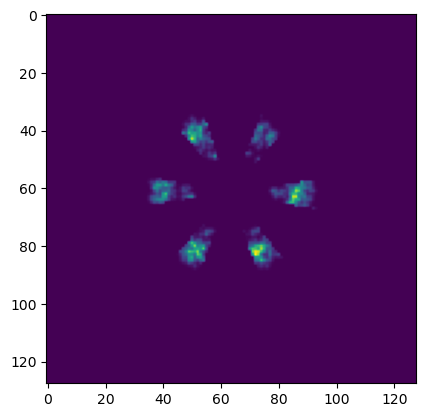

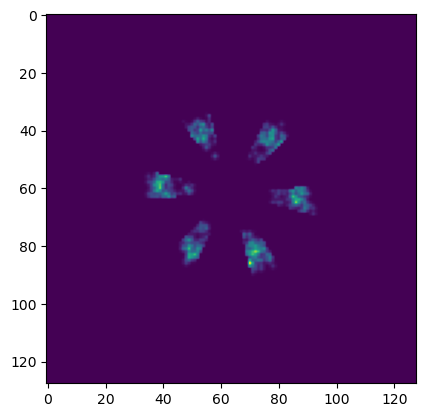

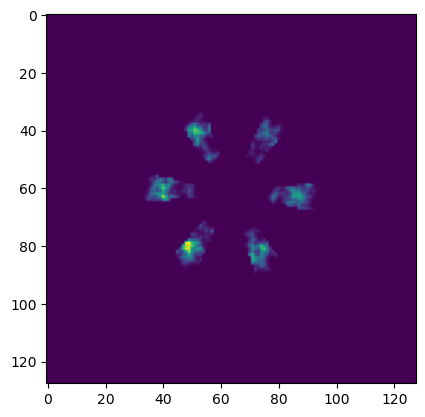

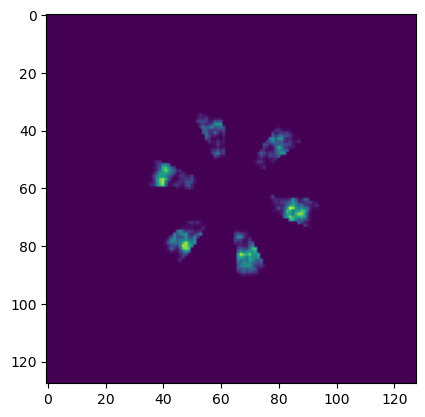

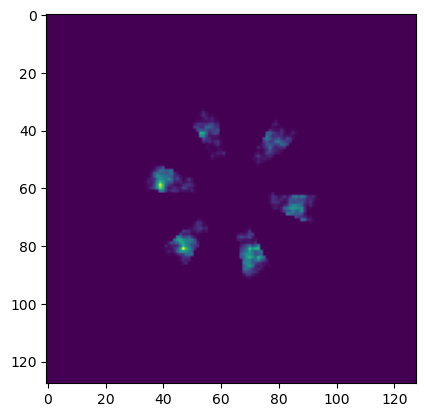

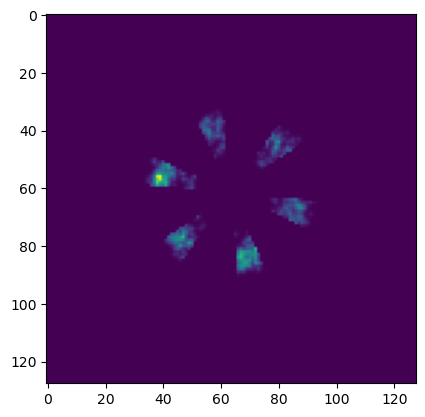

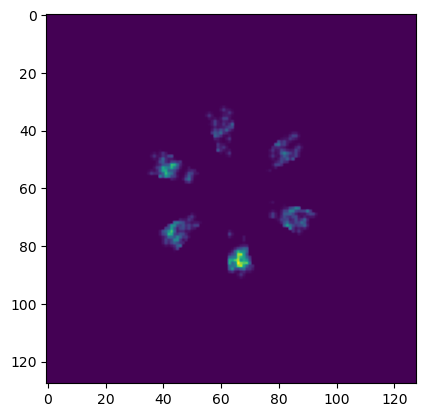

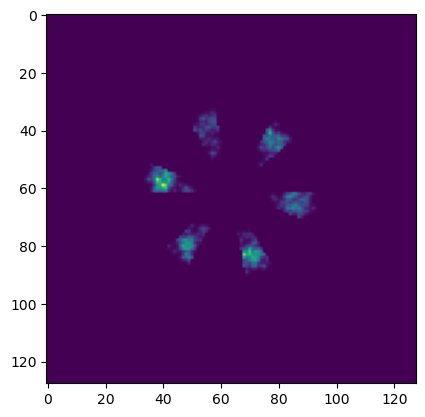

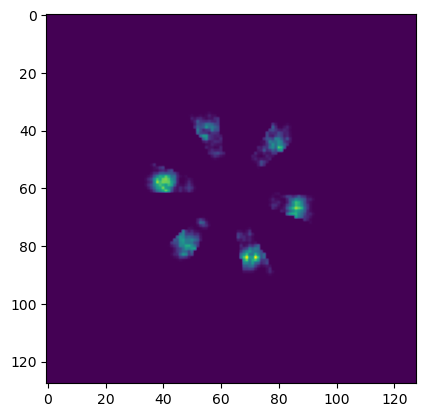

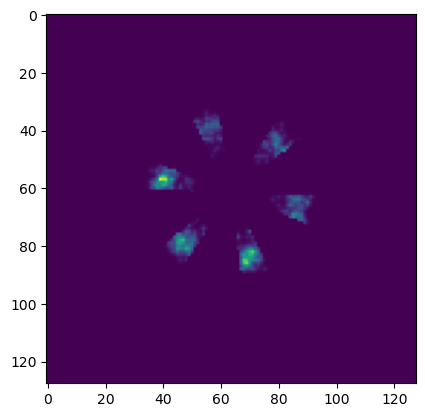

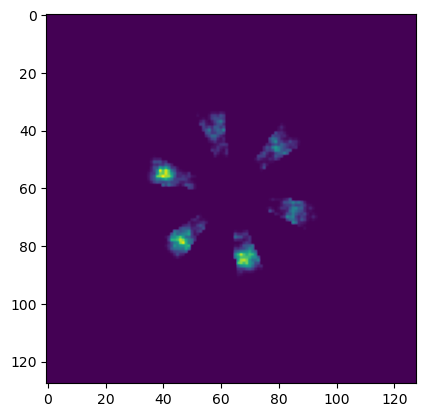

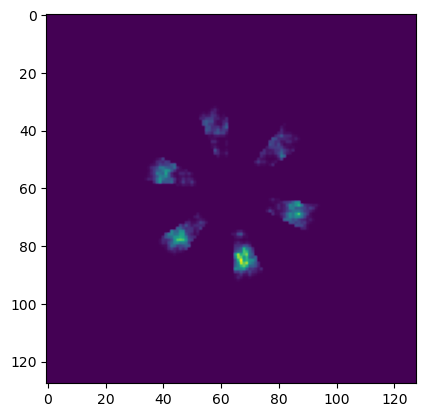

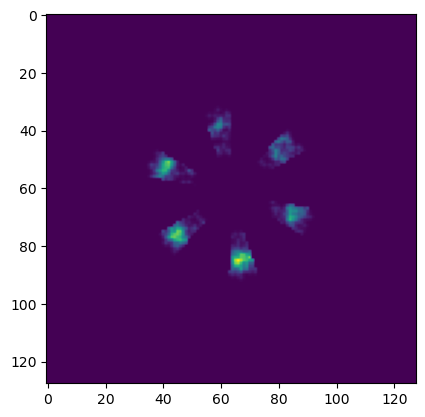

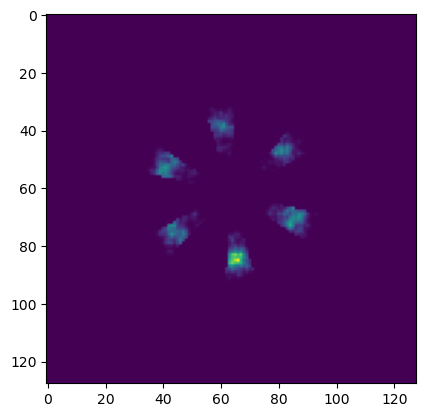

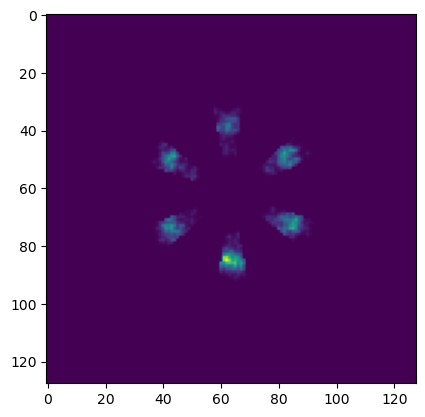

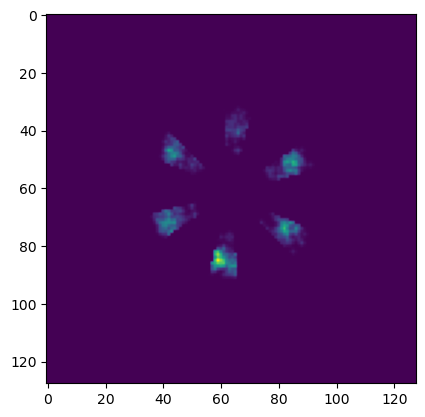

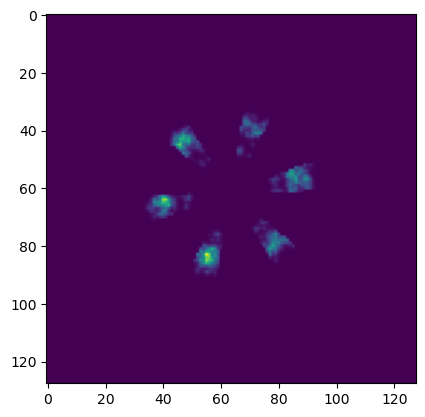

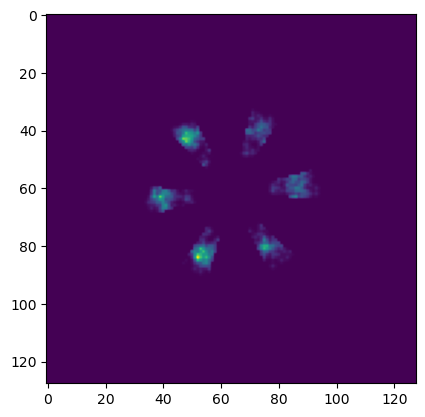

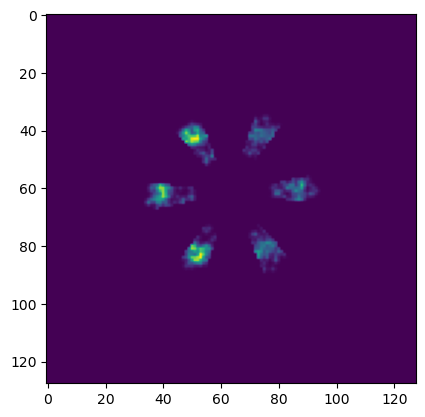

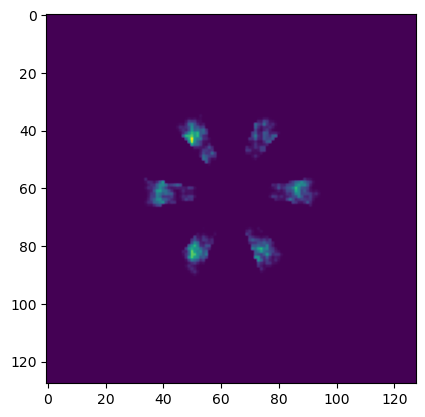

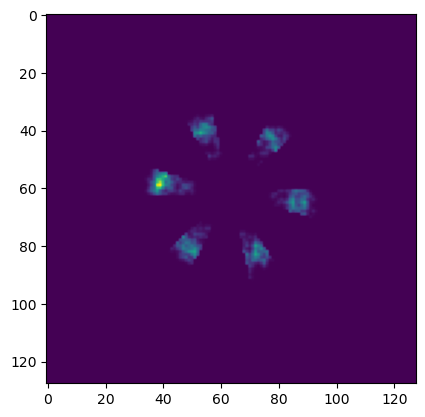

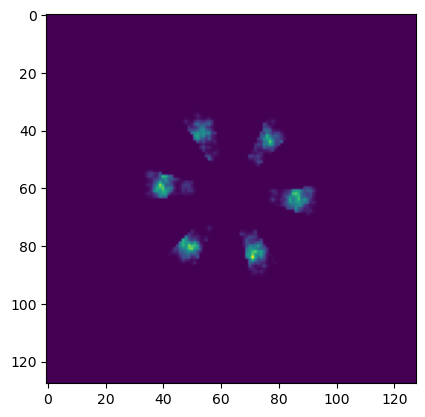

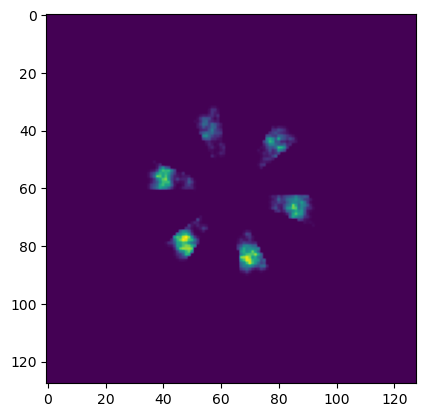

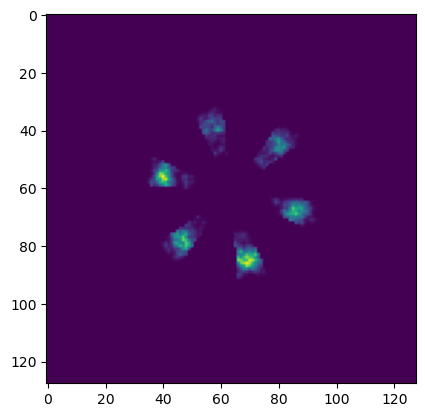

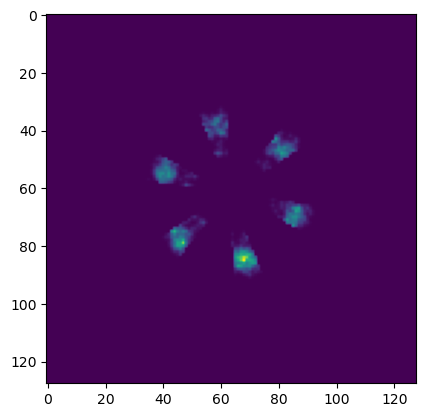

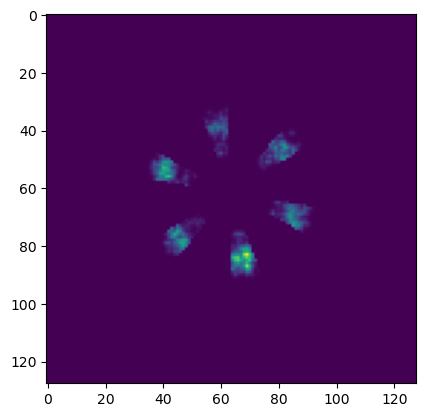

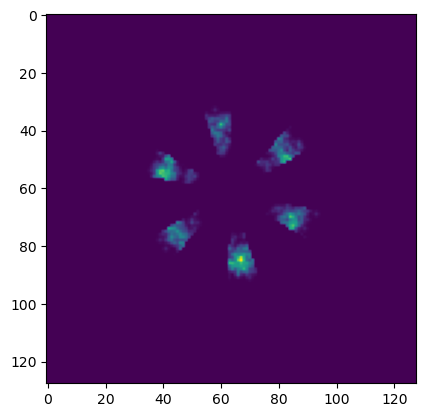

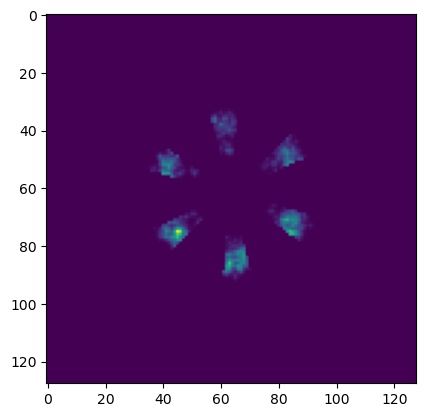

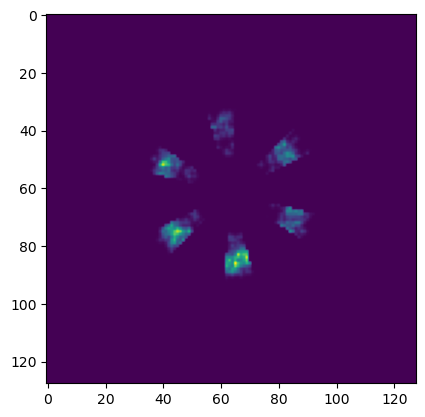

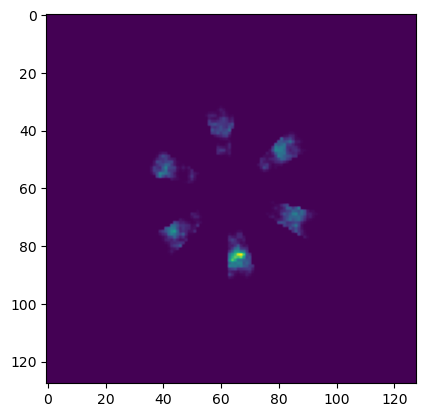

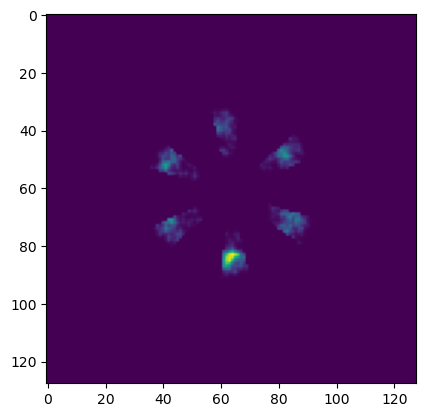

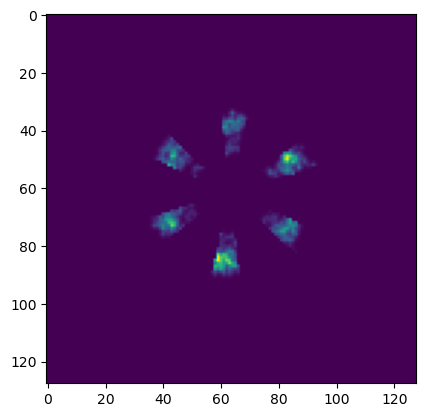

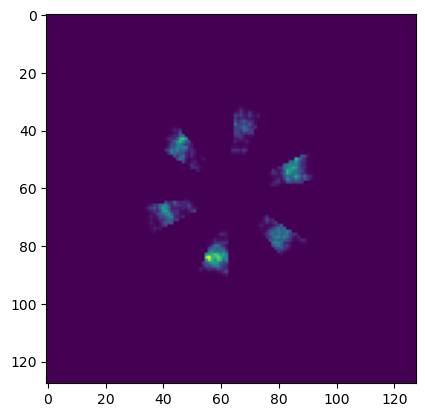

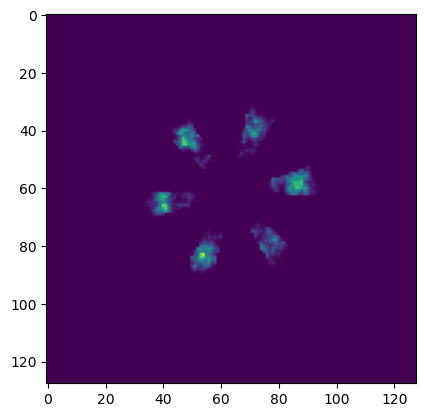

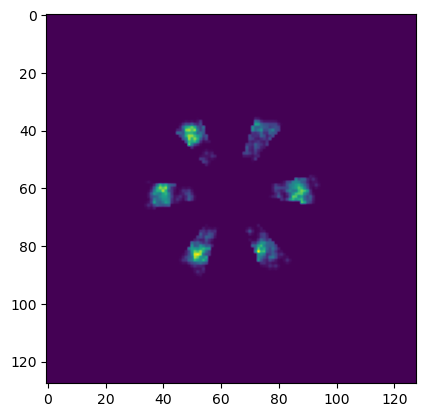

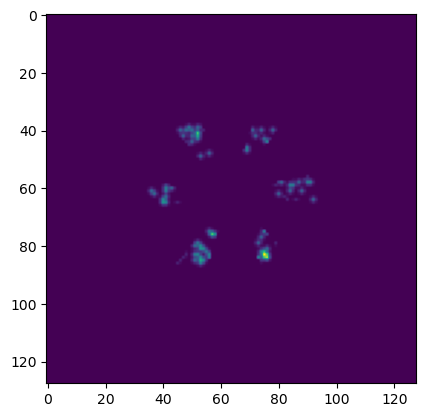

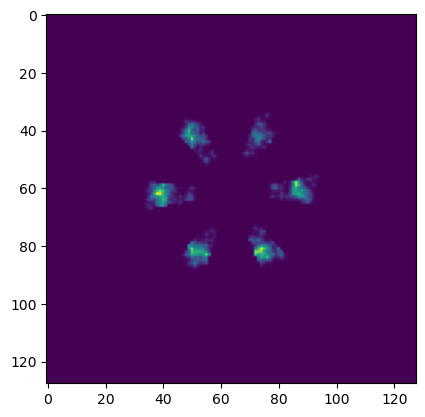

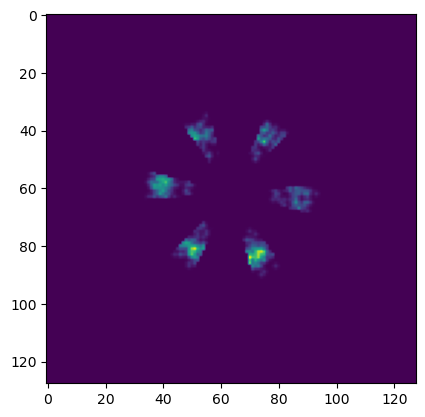

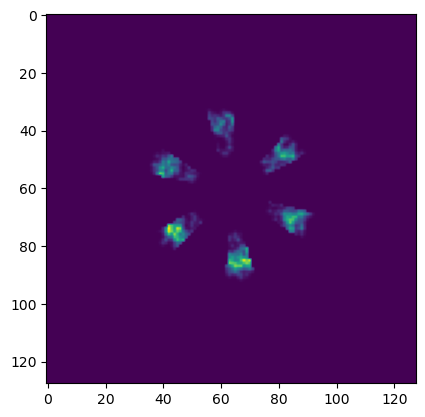

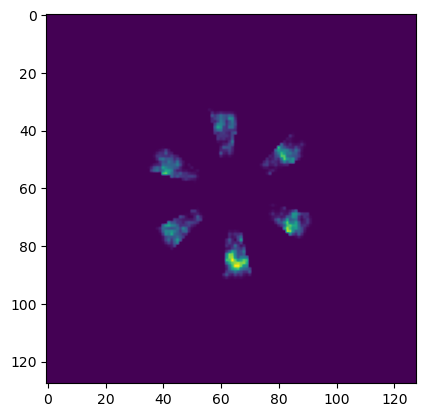

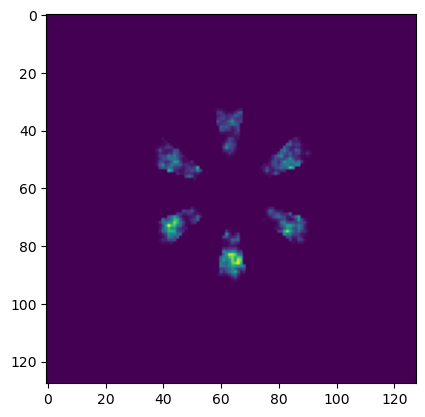

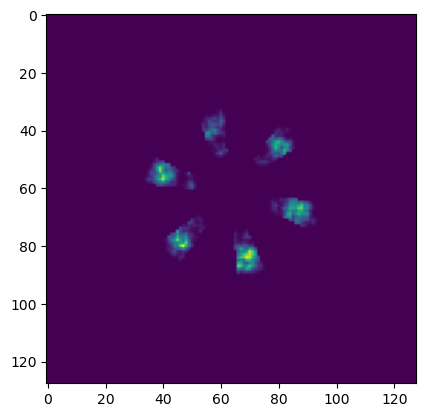

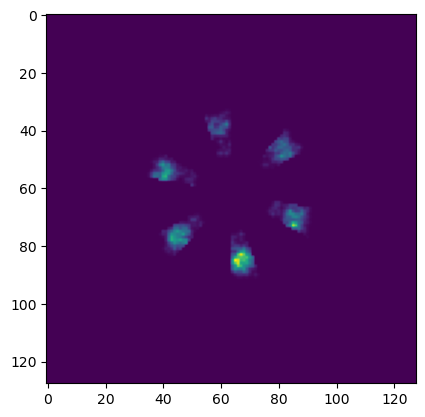

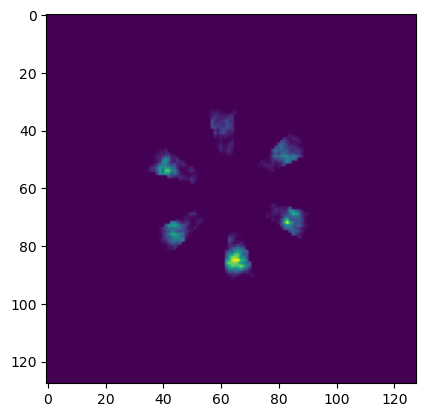

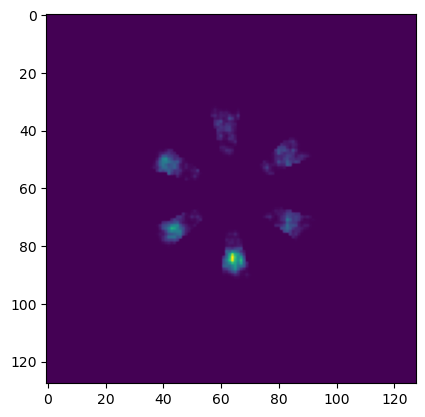

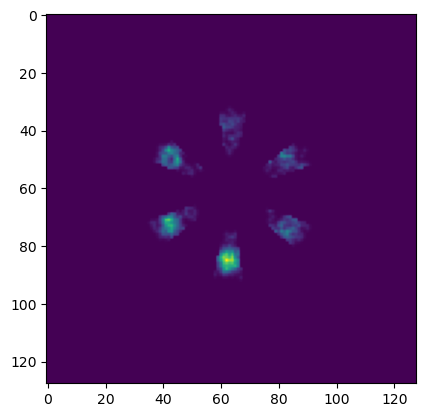

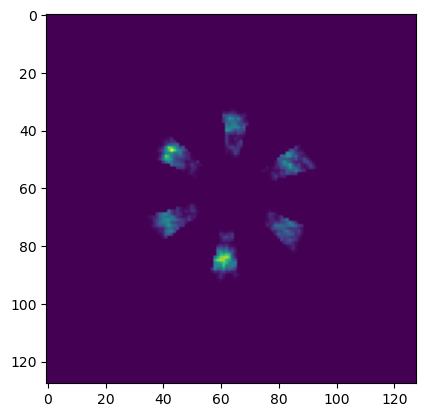

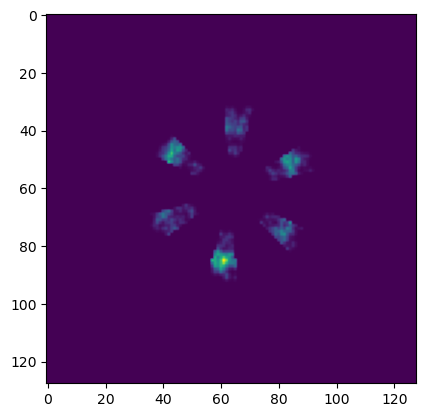

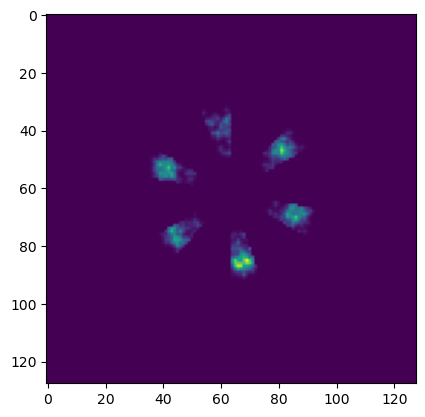

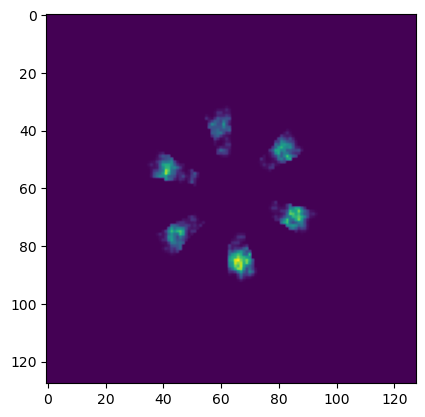

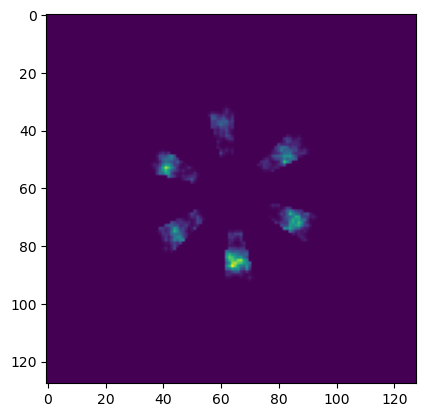

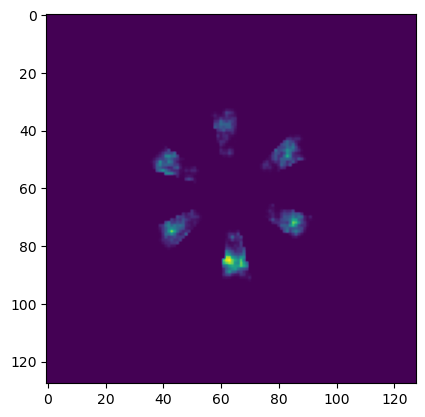

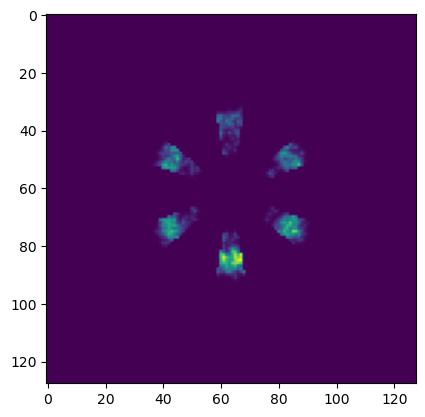

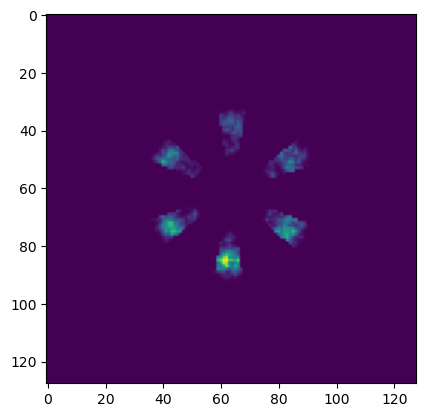

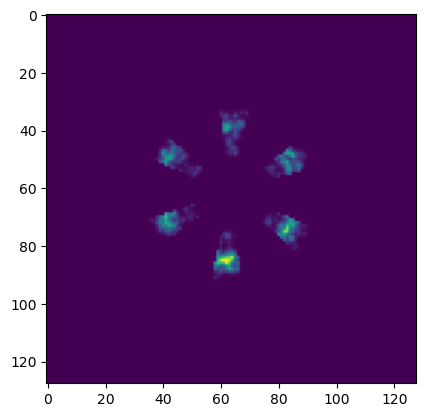

KeyboardInterrupt: 

In [10]:
# RUN GD
offset_list = []
offset1 = torch.tensor(0., requires_grad=True)
im_list = []
kmeans_ratios_list = []
filter_ratio_list = []
for i in range(end_frame):
    filtered_im = kmeans_filter[i]*images[i]
    offset, image, loss, ones_filter = gradient_descent_optimize_offset(images[i], offset1)
    plt.imshow(ones_filter*images[i])
    plt.show()
    kmeans_ratio = filtered_im.sum() / images[i].sum()
    filter_ratio = (ones_filter*images[i]).sum() / images[i].sum()
    im_list.append(image)
    offset_list.append(offset)
    kmeans_ratios_list.append(kmeans_ratio)
    filter_ratio_list.append(filter_ratio)
    # if kmeans_ratio < .6:
    #     print(i)
    #     fig, axes = plt.subplots(1, 2, figsize=(10,5))
    #     axes[0].imshow(images[i])
    #     axes[1].imshow(filtered_im)
    #     plt.show()
    # print(offset)


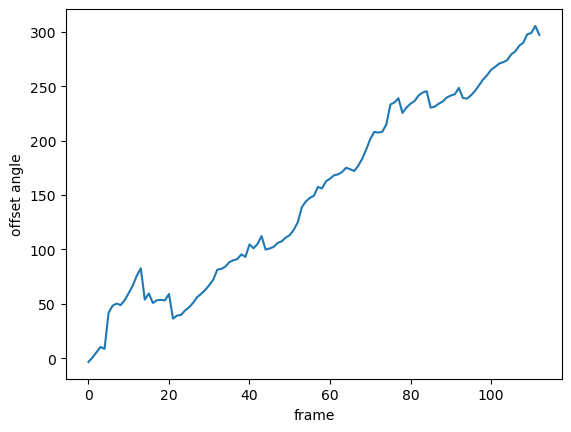

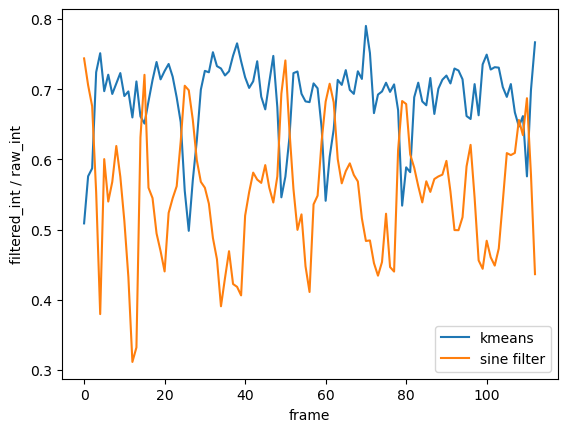

In [ ]:
# PLOT OFFSET


offset_array = np.array(offset_list)
offset_array = np.rad2deg(offset_array)
plt.plot(offset_array)
plt.ylabel('offset angle')
plt.xlabel('frame')
plt.show()

'''
the plots from below code show the ratio of total signal:

- kmeans filtering of raw image / raw image
- GD sine filter of raw image / raw image

The GD sine filter is computed by setting all values in filter above threshold
to 1 and all else to 0. This allows you to see the ratio of signal covered by GD 
compared to the total signal
'''

plt.plot(kmeans_ratios_list, label='kmeans')
plt.plot(filter_ratio_list, label='sine filter')
plt.ylabel('filtered_int / raw_int')
plt.xlabel('frame')
plt.legend()
plt.show()


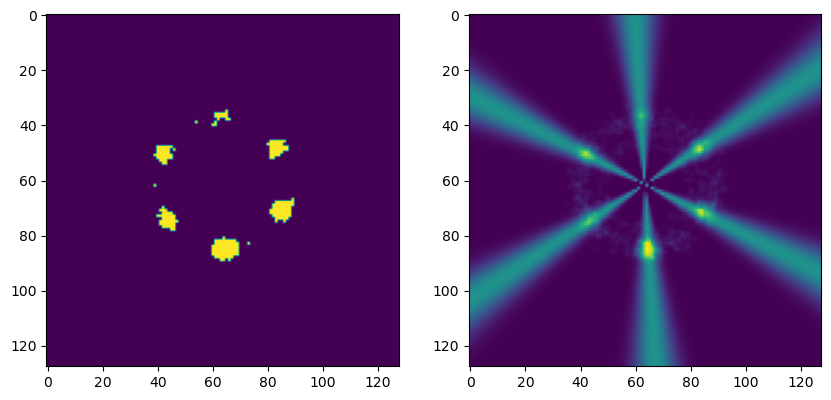

In [12]:
# MAKE GIF
from matplotlib.animation import FuncAnimation

# Define frame sampling to reduce frames if possible
end_frame = len(im_list)
frame_ranges = np.arange(0, end_frame)  # Skip every other frame for faster rendering

# Initialize figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# Display the first images in each subplot to initialize
im_display1 = ax1.imshow(kmeans_filter[0], animated=True)
im_display2 = ax2.imshow(im_list[0], animated=True)
# ax1.set_title("Image 1")
# ax2.set_title("Image 2")

# Function to update both images based on the current frame index `i`
def update(i):
    # Update image data for both subplots
    im_display1.set_array(kmeans_filter[i])
    im_display2.set_array(im_list[i])
    ax1.set_title(f'{gif.removesuffix('.npz')}: {(i + 1) * 10}s')
    ax2.set_title(f'with filter: {(i + 1) * 10}s')
# Create animation
ani = FuncAnimation(fig, update, frames=frame_ranges, interval=100)  # Adjust interval for speed (in ms)

# Save as GIF, uncomment to save
# ani.save(f'{gif.removesuffix('npz')}.gif', writer='pillow')
plt.show()


In [ ]:
for i in images[:30]:
    fourier_hexagonal_clustering(i)